# Cargue y preentrenamiento de datos

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas


In [2]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Optimal_31'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta


{'baseball_diamond': {(256, 256)},
 'basketball_court': {(256, 256)},
 'golf_course': {(256, 256)},
 'ground_track_field': {(256, 256)}}

In [3]:
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

C:\Users\nicol\AppData\Local\Temp\ipykernel_14872\279961940.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.


In [4]:
# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 47, 1: 49, 2: 48, 3: 48}


In [5]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 49, 1: 49, 2: 49, 3: 49}


In [6]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 192
Número de ejemplos de entrenamiento después del balanceo: 196
Número de ejemplos de prueba: 48


# Entrenamiento modelo customizado

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Crear un modelo secuencial
modelo = Sequential()

# Agregar una capa convolucional
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Agregar una capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar otra capa convolucional
modelo.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar otra capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar una capa de aplanamiento
modelo.add(Flatten())

# Agregar una capa totalmente conectada
modelo.add(Dense(64, activation='relu'))

# Agregar la capa de salida
modelo.add(Dense(4, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()


c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,740 (60.14 MB)

 Trainable params: 15,764,740 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - accuracy: 0.3270 - loss: 3.5379 - val_accuracy: 0.3163 - val_loss: 1.5516
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.3020 - loss: 1.4708 - val_accuracy: 0.3929 - val_loss: 1.3496
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.4765 - loss: 1.3214 - val_accuracy: 0.4184 - val_loss: 1.2214
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.4156 - loss: 1.1632 - val_accuracy: 0.5459 - val_loss: 0.9573
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.6083 - loss: 0.9214 - val_accuracy: 0.7143 - val_loss: 0.7430
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.7795 - loss: 0.6982 - val_accuracy: 0.8469 - val_loss: 0.4850
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.8833 - loss: 0.4182 - val_accuracy: 0.9592 - val_loss: 0.2888
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9472 - loss: 0.2915 - val_accuracy: 0.9541 - val_loss:

In [9]:
resultados_evaluacion = modelo.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6181 - loss: 1.0385


In [10]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Precision: 0.7302706552706554
Recall: 0.6458333333333334
F1 Score: 0.6048136003781165
Accuracy: 0.6458333333333334
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.56      0.77      0.65        13
  basketball_court       0.60      0.82      0.69        11
       golf_course       0.77      0.83      0.80        12
ground_track_field       1.00      0.17      0.29        12

          accuracy                           0.65        48
         macro avg       0.73      0.65      0.61        48
      weighted avg       0.73      0.65      0.60        48



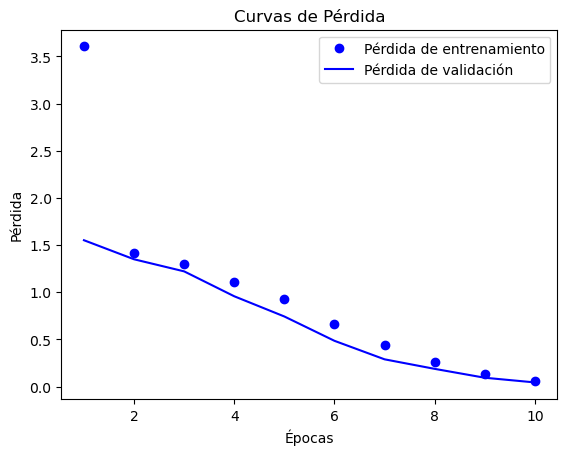

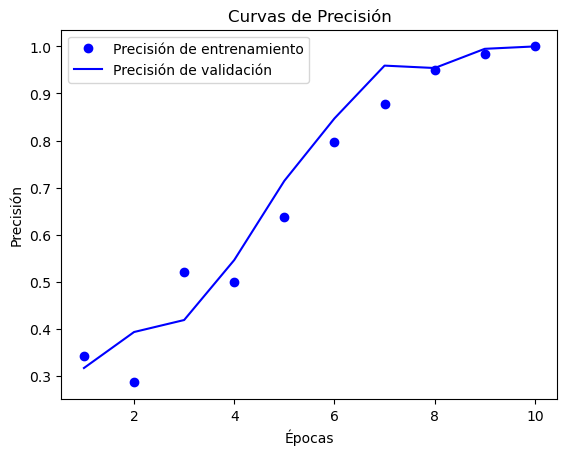

In [11]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del historial de entrenamiento
pérdida = historial_entrenamiento.history['loss']
precisión = historial_entrenamiento.history['accuracy']
val_pérdida = historial_entrenamiento.history['val_loss']
val_precisión = historial_entrenamiento.history['val_accuracy']

# Visualizar las curvas de pérdida y precisión
épocas = range(1, len(pérdida) + 1)
plt.plot(épocas, pérdida, 'bo', label='Pérdida de entrenamiento')
plt.plot(épocas, val_pérdida, 'b', label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(épocas, precisión, 'bo', label='Precisión de entrenamiento')
plt.plot(épocas, val_precisión, 'b', label='Precisión de validación')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [12]:
# Abrir la imagen
#imagen = Image.open('C:/Users/nicol/Desktop/Datasets/Dota2/part2-001/images/P1105.png')

# Redimensionar la imagen a 256x256
#imagen_redimensionada = imagen.resize((256, 256))

# Convertir la imagen redimensionada a un arreglo (matriz) y normalizarla
#imagen_arreglo = np.array(imagen_redimensionada) / 255.0

# Agregar una dimensión adicional para representar el lote
#imagen_arreglo = np.expand_dims(imagen_arreglo, axis=0)

In [13]:
# Realizar predicciones
#predicciones = modelo.predict(imagen_arreglo)

# Interpretar las predicciones
#clase_predicha = np.argmax(predicciones, axis=1)

# Visualizar resultados (opcional)
#print("Predicciones:", clase_predicha)


# Entrenamiento con VGG16

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  



In [9]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3280 - loss: 5.4505 - val_accuracy: 0.3125 - val_loss: 4.9079
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4950 - loss: 3.5531 - val_accuracy: 0.6250 - val_loss: 1.3455
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6385 - loss: 1.3004 - val_accuracy: 0.6042 - val_loss: 0.8852
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6964 - loss: 0.7545 - val_accuracy: 0.8542 - val_loss: 0.6162
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8165 - loss: 0.5107 - val_accuracy: 0.9167 - val_loss: 0.4267
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8289 - loss: 0.4186 - val_accuracy: 0.8750 - val_loss: 0.4550
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8373 - loss: 0.3843 - val_accuracy: 0.9583 - val_loss: 0.4024
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8629 - loss: 0.3816 - val_accuracy: 0.8125 - val_loss: 0.4717
Epoch 9/

In [11]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Precision: 0.8791653947903949
Recall: 0.875
F1 Score: 0.8732051282051282
Accuracy: 0.875
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.92      0.85      0.88        13
  basketball_court       0.89      0.73      0.80        11
       golf_course       0.92      1.00      0.96        12
ground_track_field       0.79      0.92      0.85        12

          accuracy                           0.88        48
         macro avg       0.88      0.87      0.87        48
      weighted avg       0.88      0.88      0.87        48



In [12]:
from tensorflow.keras.models import load_model

# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Optimal31_VGG16.h5')

# Entrenamiento con Resnet50

In [17]:
from tensorflow.keras.applications import ResNet50

# Cargar el modelo ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x) 


In [18]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2625 - loss: 18.4561 - val_accuracy: 0.2292 - val_loss: 12.0621
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2576 - loss: 8.6056 - val_accuracy: 0.2708 - val_loss: 2.1142
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2836 - loss: 1.9340 - val_accuracy: 0.2500 - val_loss: 1.3852
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2536 - loss: 1.3840 - val_accuracy: 0.2708 - val_loss: 1.3812
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2542 - loss: 1.3746 - val_accuracy: 0.2708 - val_loss: 1.3781
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2587 - loss: 1.3704 - val_accuracy: 0.2708 - val_loss: 1.3810
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2647 - loss: 1.3730 - val_accuracy: 0.3125 - val_loss: 1.3760
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3002 - loss: 1.3721 - val_accuracy: 0.2708 - val_loss: 1.3713
Epoch 

In [19]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']))

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000012E9F31AE50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Precision: 0.0625
Recall: 0.25
F1 Score: 0.10000000000000002
Accuracy: 0.25
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.00      0.00    

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicol\anaconda3\lib\site-packag

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])


# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [12]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet-18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para que coincida con el número de clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Suponiendo 6 clases

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [14]:
# Número de épocas
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')



Epoch 1, Loss: 1.4430047614233834
Epoch 2, Loss: 1.2433101790291923
Epoch 3, Loss: 1.0593139103480749
Epoch 4, Loss: 0.9953879288264683
Epoch 5, Loss: 0.8370662757328579
Epoch 6, Loss: 0.7785383462905884
Epoch 7, Loss: 0.7329944031579154
Epoch 8, Loss: 0.6667718206133161
Epoch 9, Loss: 0.6381551197596959
Epoch 10, Loss: 0.5988051252705711


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')



Accuracy: 81.25000%
Precision: 0.83001
Recall: 0.81250
F1 Score: 0.80972


# Modelo Preentrenado Xception con ImageNet

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  



In [12]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.3057 - loss: 10.8503 - val_accuracy: 0.7500 - val_loss: 3.7771
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7598 - loss: 4.3663 - val_accuracy: 0.7708 - val_loss: 2.9808
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8614 - loss: 1.5724 - val_accuracy: 0.7500 - val_loss: 1.2186
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9134 - loss: 0.9407 - val_accuracy: 0.8542 - val_loss: 1.1477
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9455 - loss: 0.2951 - val_accuracy: 0.8542 - val_loss: 1.1039
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9412 - loss: 0.4125 - val_accuracy: 0.8958 - val_loss: 1.0743
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.9622 - loss: 0.3596 - val_accuracy: 0.8750 - val_loss: 1.1065
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9267 - loss: 0.4860 - val_accuracy: 0.8750 - val_loss: 0.8567
Epoch 9

In [13]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Precision: 0.8679315476190476
Recall: 0.8541666666666666
F1 Score: 0.8438644688644689
Accuracy: 0.8541666666666666
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.88      0.54      0.67        13
  basketball_court       1.00      0.91      0.95        11
       golf_course       0.86      1.00      0.92        12
ground_track_field       0.75      1.00      0.86        12

          accuracy                           0.85        48
         macro avg       0.87      0.86      0.85        48
      weighted avg       0.87      0.85      0.84        48



# Entrenamiento con MobileNet Preentrenado con Imagenet

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (6 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

model = model.to(device)


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
        
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


Epoch 1, Loss: 1.0506577747208732
Epoch 2, Loss: 0.6127954625657627
Epoch 3, Loss: 0.470165063227926
Epoch 4, Loss: 0.15184941036360605
Epoch 5, Loss: 0.2656162311988218
Epoch 6, Loss: 0.2524272496146815
Epoch 7, Loss: 0.38016000097351416
Epoch 8, Loss: 0.30913023012025015
Epoch 9, Loss: 0.21802767366170883
Epoch 10, Loss: 0.21845364570617676


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 87.50000%
Precision: 0.89435
Recall: 0.87500
F1 Score: 0.86665
